In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from scipy.optimize import curve_fit
import os
import numpy as np
import glob

In [2]:
# Define exponential function func,  
# where a = alpha, b = Tau, c = y intercept

def fit_to_exponential(x, a, b, c):
     return a * np.exp(-(x / b)) + c

In [3]:
outpath_fig = './dataFolders/Output/Figures/ExponentionalFitWithBounds/'
outpath = './dataFolders/Output/Step6_FloralTypeConsolidatedData_AndFitParameters/'

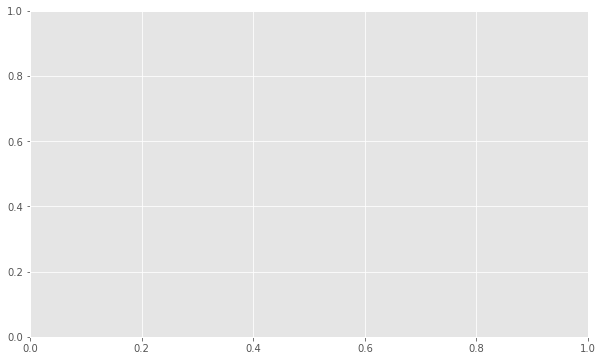

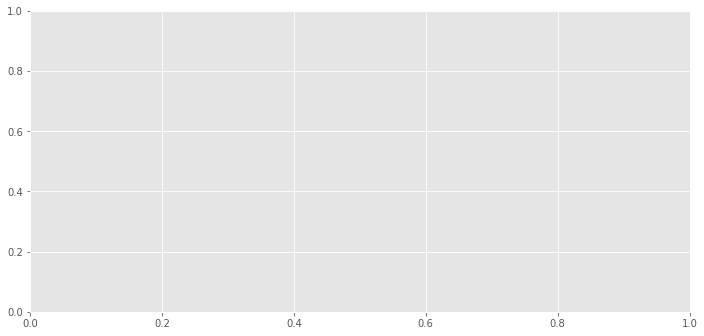

In [10]:
# do the fit for three different y0 - computed across different lengths of the saturation - curve
shapes = ['c-1', 'c-2','c-3', 'c-10']
fig1, ax0 = plt.subplots(figsize = (10,6))
fig2, ax1 = plt.subplots(figsize = (10,6))

for floralShape in shapes:
    tau = []
    covariance = []
    
    file  = glob.glob(outpath + floralShape + '_Alltrials.csv')
    new_df = pd.read_csv(file[0])
    
    xdata = new_df.trialNum.values
    ydata = new_df.DiscoveryTime.values
    
    xdata_notnan = new_df[new_df.DiscoveryTime.notnull()].trialNum.values
    ydata_notnan = new_df[new_df.DiscoveryTime.notnull()].DiscoveryTime.values
    numMoth = len(new_df.name.unique())
    
    param_file = glob.glob(outpath + floralShape + '_FittedParameters.csv')
    param_df = pd.read_csv(param_file[0])
    
    length_to_estimate_y0 = [2, 4, 8]

    for length in length_to_estimate_y0:
        if length ==2:
            idx = 0
        elif length == 4:
            idx = 1
        else:
            idx = 2
        
        a0 = param_df.loc[idx,'alpha']
        mean_y0 = param_df.loc[idx, 'y_intercept']
        
        popt,pcov = curve_fit(lambda x, b: fit_to_exponential(x, a0, b, mean_y0),
                              xdata_notnan, ydata_notnan, bounds = (0, np.inf))
        tau.append(popt[0]/100)
        covariance.append(pcov.flatten()[0])

        # plot the final curve fit
        max_trial=max(xdata)
        ax1.plot(xdata, ydata*1/100, 'or', markersize=7, alpha=.5, label = 'Raw data')
        ax1.plot(range(0,max_trial), fit_to_exponential(range(0,max_trial), a0, *popt, mean_y0)*1/100, 
                 'g--', linewidth=2, 
                 label = 'fit: alpha= %5.3f , Tau= %5.3f, y0= %5.3f' %(a0/100, popt/100, mean_y0/100))

        ax1.set_title(floralShape + '_1-' + str(length) + '_length', y=1.2)
        ax1.set_xlabel('Trial number')
        ax1.set_ylabel('Exploration Time (second)')
        leg = plt.legend()
        leg.get_frame().set_linewidth(1.5)
        ax1.legend(bbox_to_anchor=(0., 1.05, 1., .102), loc=3, mode="expand", borderaxespad=0.)
        ax1.set_xlim([-5,90])
        ax1.set_ylim([-5,55])
        ax1.text(60, 40, 'N= ' + str(numMoth))
        fig2.tight_layout()
        fig2.savefig(outpath_fig + 'LearningCurve_' + floralShape + '_1-' + str(length) + '_length.svg')
        ax1.cla()

    expo_param_df = pd.DataFrame({'tau':tau,
                                 'covariance':covariance}, 
                                index = ['one-half', 'last fourth', 'last eight'])
    expo_param_df.to_csv(outpath + floralShape + '_BoundedExponentialFittedParameters.csv')

9.531676691729324